## Dynamic Graph Encoder
The input is first put through a gated graph convolution unit from PyTorch Geometric. <br />
Its output is fed into as standard pytorch LSTM unit. <br />

The output of the DyGrEncoder is the last hidden state of the last LSTM layer. <br />

In this example, the features of a single time step are expanded with the conv unit <br />
and then sequentially integrated using the LSTM.<br />

The H, C inputs to the DyGrEncoder are used to initialize the LSTM states. <br />
The hidden and cell state are expanded internally to (1, ...), meaning one LSTM layer. <br />
Therefore, more than one LSTM layer will fail to execute unless the initial states are _None_. <br />


### GyGrEncoder

100%|██████████| 200/200 [06:29<00:00,  1.95s/it]


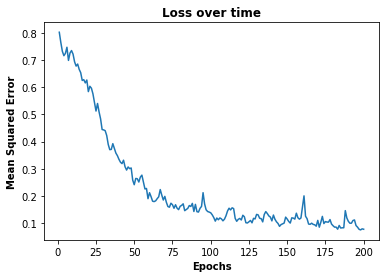

Train MSE: 0.0775
Test MSE: 0.9859


In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.nn.recurrent import DyGrEncoder

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

lags = 10
epochs = 200

dataset = loader.get_dataset(lags)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

### MODEL DEFINITION
class RecurrentGCN(nn.Module):
    def __init__(self):
        super(RecurrentGCN, self).__init__()

        self.rnn = DyGrEncoder(
            conv_out_channels=32, 
            conv_num_layers=1, 
            conv_aggr='mean', 
            lstm_out_channels=64, 
            lstm_num_layers=1
        )
        
        self.out = nn.Sequential(
            nn.Linear(64, 32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Flatten(start_dim=0, end_dim=-1)
        )

    def forward(self, window, h, c):        
        edge_index = window.edge_index
        x = window.x

        H, C = [], []
        for t in range(lags):
            x_t = x[:,t].unsqueeze(0).T
            h_tilde, h, c = self.rnn(x_t, edge_index, None, h, c)
            
            H.append(h.detach())
            C.append(c.detach())

        pred = self.out(h_tilde)

        return pred, H, C
    
model = RecurrentGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    h, c = None, None
    for i, window in enumerate(train_dataset):
        optimizer.zero_grad()
        
        y_pred, H, C = model(window, h, c)

        h = H[0]
        c = C[0]
    
        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    h, c = None, None
    for i, window in enumerate(test_dataset):

        y_pred, H, C = model(window, h, c)

        h = H[0]
        c = C[0]
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()

print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))
